In [2]:
import os
import dask.dataframe as dd
import pandas as pd

os.environ['NIXTLA_ID_AS_COL'] = '1'

# Chemin du dossier contenant les fichiers .csv
dossier = '../../../../erc20_balance_export/2024'

# Lister tous les fichiers dans le dossier
fichiers = os.listdir(dossier)

# Filtrer les fichiers pour ne garder que ceux avec l'extension .csv
fichiers_csv = [f for f in fichiers if f.endswith('.csv')]

# Initialiser une liste pour stocker les DataFrames Dask
dataframes = []

# Par exemple, 50MB par partition
blocksize = 50 * 1024 * 1024  # 50MB

# Boucler sur chaque fichier .csv et lire son contenu avec Dask
for fichier_csv in fichiers_csv:
    chemin_complet = os.path.join(dossier, fichier_csv)
    df = dd.read_csv(chemin_complet)
    # Filtrer les lignes avec la colonne "token_address" égale à "0x...TOKEN"
    filtered_df = df[df['token_address'] == '0xdac17f958d2ee523a2206206994597c13d831ec7'.lower()]
    # Pour déclencher l'exécution et afficher le résultat
    result = filtered_df.compute()
    dataframes.append(result)

# Combiner tous les DataFrames Dask en un seul DataFrame Dask
df_combine = dd.concat(dataframes)

# Afficher les premières lignes du DataFrame Dask
df_combine.head()


,timestamp,wallet_address,token_address,balance
259,2024-01-13,0x065f03b5c44614def3544154976e09e01fa9f28d,0xdac17f958d2ee523a2206206994597c13d831ec7,17.141376
260,2024-01-13,0x4bf5298778cc3903a73ef001ba4898057a9b4c15,0xdac17f958d2ee523a2206206994597c13d831ec7,17.144785
261,2024-01-13,0xac84646b983bab0c8f8248636ba23178b5af83c0,0xdac17f958d2ee523a2206206994597c13d831ec7,17.148945
262,2024-01-13,0x08750dbd533ffc9f4f9a908c94e8ca199fbf1ab3,0xdac17f958d2ee523a2206206994597c13d831ec7,17.215120
263,2024-01-13,0xaecb708998fc76ddbe801f307a32d68140ad5c00,0xdac17f958d2ee523a2206206994597c13d831ec7,17.215053


In [42]:
df_without_token_address = df_combine.drop(columns=['token_address'])

# Group by 'wallet_address' and count the number of rows for each
wallet_counts = df_without_token_address.groupby('wallet_address').size().compute()

# Filter the wallet addresses with at least 50 rows
valid_wallets = wallet_counts[wallet_counts >= 10].index

# Filter the original DataFrame based on the valid wallet addresses
filtered_df = df_without_token_address[df_without_token_address['wallet_address'].isin(valid_wallets)]

# Display the resulting DataFrame
filtered_df.compute()


,timestamp,wallet_address,balance
259,2024-01-13,0x065f03b5c44614def3544154976e09e01fa9f28d,17.141376
260,2024-01-13,0x4bf5298778cc3903a73ef001ba4898057a9b4c15,17.144785
262,2024-01-13,0x08750dbd533ffc9f4f9a908c94e8ca199fbf1ab3,17.215120
267,2024-01-13,0xceb69f6342ece283b2f5c9088ff249b5d0ae66ea,17.240288
268,2024-01-13,0x860e7f302e288ba19b5b458f99d135d2a65c7d7a,17.239758
...,...,...,...
568410,2024-03-29,0xd80bb4401022eb615c8a3f9be0c160d8de195076,-0.824527
568422,2024-03-29,0x543a3dba8948463a5413b3008a35f7029771be7f,-0.806567
568426,2024-03-29,0x659e2cca96179288c80e2ae8ee9ae4ce73d95a78,-0.768293
568428,2024-03-29,0xfc6275e2159cf9f8e1524db3cb9744050b33ee28,-0.780353


In [43]:
# Reset index to make 'wallet_address' a regular column
#filtered_df = filtered_df.reset_index(drop=False)
filtered_df['timestamp'] = dd.to_datetime(filtered_df['timestamp'])

# Create a DataFrame with all combinations of wallet addresses and dates
dates = pd.date_range(start='2024-01-01', end='2024-04-01', freq='D')
wallet_addresses = filtered_df['wallet_address'].unique()
wallet_date_df = pd.DataFrame([(wallet, date) for wallet in wallet_addresses for date in dates], columns=['wallet_address', 'timestamp'])

# Convert wallet_date_df to a Dask DataFrame
wallet_date_ddf = dd.from_pandas(wallet_date_df, npartitions=1)

# Merge wallet_date_ddf with filtered_df to fill in missing values
merged_df = wallet_date_ddf.merge(filtered_df, on=['wallet_address', 'timestamp'], how='left')

# Fill missing values with the previous known value
filled_df = merged_df.ffill().compute()

# Now filled_df contains the desired DataFrame with each wallet_address having a row for each day from 2024-01-01 to 2024-04-01
filled_df


,wallet_address,timestamp,balance
0,0x065f03b5c44614def3544154976e09e01fa9f28d,2024-01-08,11.154900
1,0x065f03b5c44614def3544154976e09e01fa9f28d,2024-01-22,11.154900
2,0x065f03b5c44614def3544154976e09e01fa9f28d,2024-01-27,11.154900
3,0x065f03b5c44614def3544154976e09e01fa9f28d,2024-01-28,11.154900
4,0x065f03b5c44614def3544154976e09e01fa9f28d,2024-01-30,11.154900
...,...,...,...
1632033,0x357c6fd2cee77ba5de49e0bb9d49444781a8f0cc,2024-02-04,-2.685882
1632034,0x357c6fd2cee77ba5de49e0bb9d49444781a8f0cc,2024-02-09,-2.685882
1632035,0x357c6fd2cee77ba5de49e0bb9d49444781a8f0cc,2024-02-22,-2.685882
1632036,0x357c6fd2cee77ba5de49e0bb9d49444781a8f0cc,2024-02-23,-2.685882


In [44]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

filled_df.columns = ['unique_id','ds','y']

sf = StatsForecast(
    models = [AutoARIMA(season_length = 92)],
    freq = 'D'
)

sf.fit(filled_df)
pred = sf.predict(h=12, level=[95])

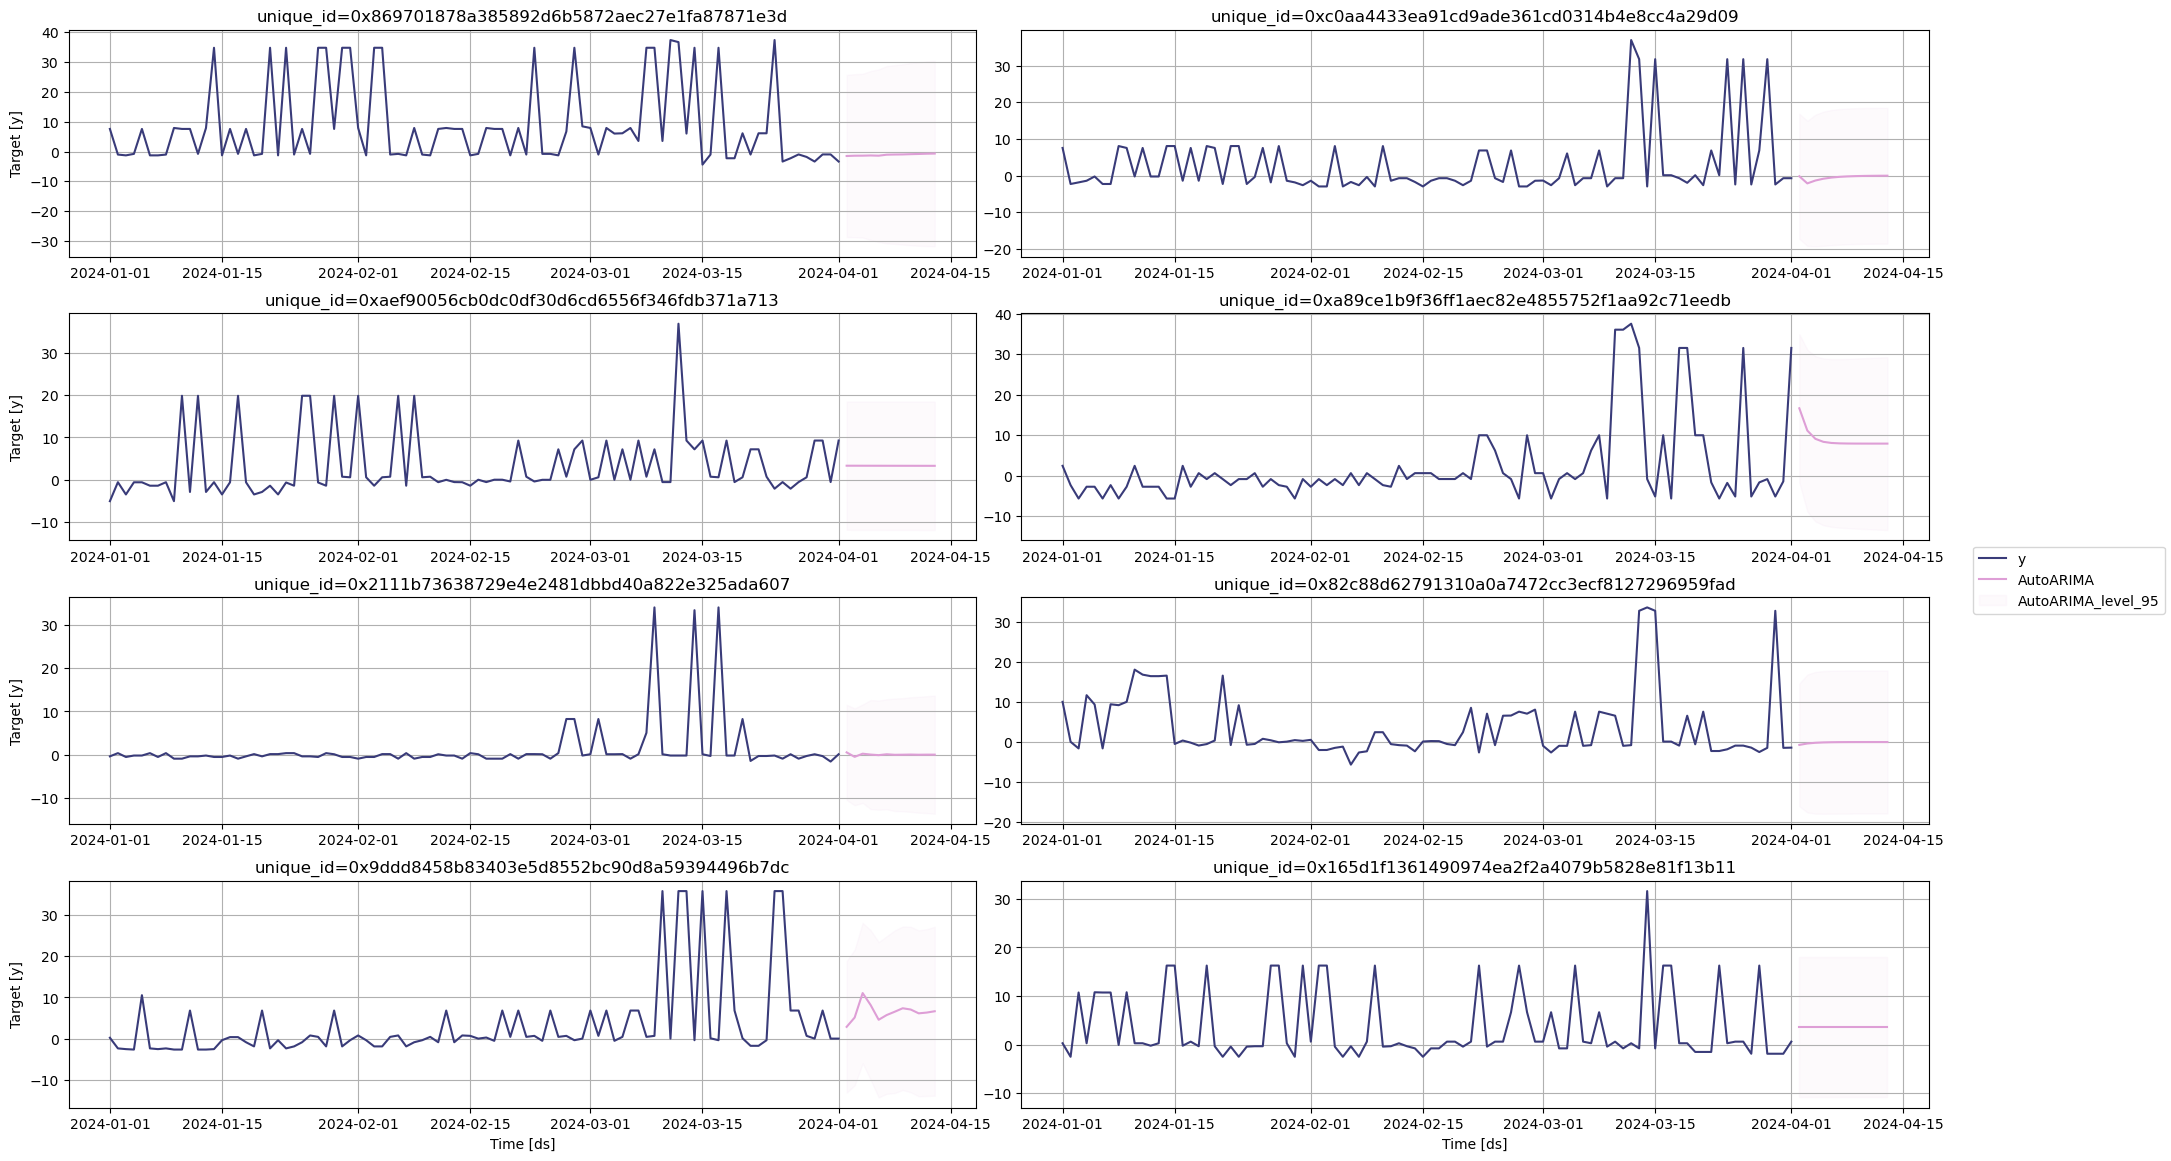

In [45]:
StatsForecast.plot(filled_df,pred,level=[95])


In [50]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

crossvaldation_df = sf.cross_validation(
    df=filled_df,
    h=12,
    step_size=12,
    n_windows=2
)

def evaluate_cross_validation(df, metric):
    #models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models="AutoARIMA")
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    #evals['best_model'] = evals.idxmin(axis=1)
    return evals

evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,0
unique_id,
0x0000000000000000000000000000000000000000,18.489740
0x000000000069181d0c2a2c7ce97171d4d75cd0b4,19.953070
0x000000000da81eaf18b610009494549a9396e736,278.256897
0x00000000be193a3bfaf4c6627ba14b1f2dbdddad,27.452133
0x00000000d7c185343e6504e428b8f8b5ad6c91b8,172.156616
